In [1]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ARQUIVO_SOLARIMETRO = '~/sonda-translator/output/sonda-banco-dados/Solarimetrica.parquet'
NOME_DA_TABELA = 'solarimetrica'

In [3]:
con = duckdb.connect(database=':memory:')

In [4]:
# Cria as tabelas no banco de dados DuckDB a partir dos arquivos Parquet
con.execute(f"""CREATE TABLE IF NOT EXISTS {NOME_DA_TABELA} AS \
            SELECT * FROM read_parquet('{ARQUIVO_SOLARIMETRO}')""")

In [5]:
# Exibe as primeiras linhas da tabela meteorológica
con.execute(f"SELECT * FROM {NOME_DA_TABELA} LIMIT 5").fetch_df()

,acronym,timestamp,year,day,min,glo_avg,glo_std,glo_max,glo_min,dif_avg,...,dir_min,lw_avg,lw_std,lw_max,lw_min,temp_glo,temp_dir,temp_dif,temp_dome,temp_case
0,SLZ,2015-03-01 02:07:00,2015,60,127.0,-1.305,0.000,-1.305,-1.305,-1.292,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,SLZ,2015-03-01 12:28:00,2015,60,748.0,687.900,11.010,706.000,670.900,652.500,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2,SLZ,2015-03-01 13:00:00,2015,60,780.0,615.200,41.950,689.200,556.000,573.100,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,SLZ,2015-03-01 17:41:00,2015,60,1061.0,159.000,1.609,161.800,156.000,141.000,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
4,SLZ,2015-03-01 22:32:00,2015,60,1352.0,-0.653,0.000,-0.653,-0.653,-1.276,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [6]:
def verifica_temporal(base):
    # Faz um agrupamento por acronym e timestamp para verificar se os dados são temporais, fazendo a contagem de registros por dia
    query = f"""
    SELECT acronym, DATE_TRUNC('year', timestamp) AS data, COUNT(*) AS registros
    FROM {base}
    GROUP BY acronym, data
    ORDER BY data
    """
    return con.execute(query).fetch_df()

In [7]:
temporal_solar = verifica_temporal(NOME_DA_TABELA)

In [8]:
def plot_tempora(df, titulo):
    df["year"] = df["data"].dt.year
    df["month"] = df["data"].dt.month
    df = df.dropna(subset=["year"])
    df["year"] = df["year"].astype(int)
    # Reagrupando os dados para evitar duplicatas ao pivotar
    df_grouped = df.groupby(["acronym", "year"])["registros"].sum().reset_index()
    # Criando a matriz pivot corrigida
    heatmap_data = df_grouped.pivot(index="acronym", columns="year", values="registros")
    # Criando a figura
    plt.figure(figsize=(8, max(4, len(heatmap_data) * 0.2)))  # Ajusta dinamicamente o tamanho
    sns.heatmap(heatmap_data, cmap="coolwarm_r", linewidths=0.5, linecolor="gray", 
                cbar_kws={'label': 'Número de Registros'}, annot=False)
    # Ajustando o gráfico
    plt.title(titulo)
    plt.xlabel("Ano")
    plt.ylabel("Estação")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

/tmp/ipykernel_4045501/2974472146.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["year"].astype(int)


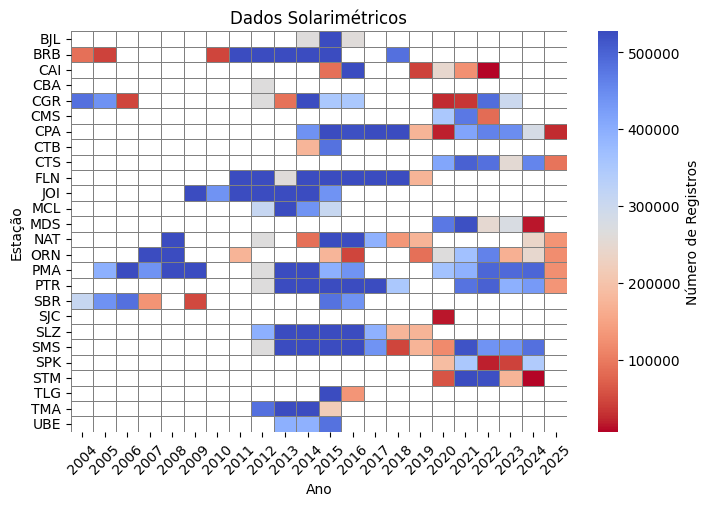

In [9]:
plot_tempora(temporal_solar, 'Dados Solarimétricos')